Подключение гугл диска

In [4]:
from google.colab import drive
drive.mount('/content/drive')
number_of_interations = 2
print('Текущий номер для сохранения модели, чекпоинтов, а также загрузки существующей модели с облака: ', number_of_interations)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Текущий номер для сохранения модели, чекпоинтов, а также загрузки существующей модели с облака:  2


Библиотеки

In [5]:
from pandas import read_csv
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
from tensorflow.keras import layers

Keras SimpleRNN
The function below returns a model that includes a SimpleRNN layer and a Dense layer for learning sequential data. The input_shape specifies the parameter (time_steps x features). We’ll simplify everything and use univariate data, i.e., one feature only; the time_steps are discussed below.

In [6]:
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = keras.Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape, activation = activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    #model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics=['accuracy'])
    return model

demo_model = create_RNN(5, 1, (3,1), activation=['relu', 'softmax'])
demo_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 5)                 35        
_________________________________________________________________
dense (Dense)                (None, 1)                 6         
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [7]:
wx = demo_model.get_weights()[0]
wh = demo_model.get_weights()[1]
bh = demo_model.get_weights()[2]
wy = demo_model.get_weights()[3]
by = demo_model.get_weights()[4]
 
print('wx = ', wx, ' wh = ', wh, ' bh = ', bh, ' wy =', wy, 'by = ', by)

wx =  [[-0.76057076 -0.8678055  -0.16214848 -0.35040617 -0.65448546]]  wh =  [[ 0.37100446  0.6608366  -0.1544841  -0.5589039  -0.29901794]
 [ 0.5767455  -0.57999593  0.32287332 -0.15048273 -0.45174873]
 [-0.3529825  -0.04183241 -0.42926988  0.25723353 -0.7894374 ]
 [ 0.35228398 -0.31811336 -0.82893693 -0.06732254  0.28815123]
 [ 0.5301129   0.35207015  0.02187269  0.7708954  -0.01638827]]  bh =  [0. 0. 0. 0. 0.]  wy = [[-0.9897654 ]
 [ 0.52108884]
 [ 0.00717711]
 [ 0.2744677 ]
 [-0.6213324 ]] by =  [0.]


In [8]:
x = np.array([1, 2, 3, 4, 5, 6])

# Reshape the input to the required sample_size x time_steps x features 
x_input = np.reshape(x,(1, 6, 1))
y_pred_model = demo_model.predict(x_input)
 
m = 5
h0 = np.zeros(m)
h1 = np.dot(x[0], wx) + h0 + bh
h2 = np.dot(x[1], wx) + np.dot(h1,wh) + bh
h3 = np.dot(x[2], wx) + np.dot(h2,wh) + bh
h4 = np.dot(x[3], wx) + np.dot(h3,wh) + bh
h5 = np.dot(x[4], wx) + np.dot(h4,wh) + bh
h6 = np.dot(x[5], wx) + np.dot(h5,wh) + bh
output = np.dot(h6, wy) + by

#print('h1 = ', h1,'h2 = ', h2,'h3 = ', h3) 
print('h1 = ', h1,'h2 = ', h2,'h3 = ', h3, 'h4 = ', h4, 'h5 = ', h5, 'h6 = ', h6)
 
print("Prediction from network ", y_pred_model)
print("Prediction from our computation ", output)

h1 =  [[-0.76057076 -0.86780548 -0.16214848 -0.35040617 -0.65448546]] h2 =  [[-2.7169777  -1.84707315 -0.14123739 -0.66779629 -0.65175462]] h3 =  [[-4.88591745 -3.33871991 -0.06315189  0.25145556 -0.3868655 ]] h4 =  [[-6.87477907 -4.9771243  -1.16157436  1.50014694  0.47994932]] h5 =  [[-8.03104114 -6.25507053 -2.09007957  2.8094822   2.37305841]] h6 =  [[-8.16507452 -6.85694089 -3.13158834  4.43002289  3.72088517]]
Prediction from network  [[1.]]
Prediction from our computation  [[3.38994885]]


In [9]:
# Parameter split_percent defines the ratio of training examples
def get_train_test(url, split_percent=0.8):
    df = read_csv(url, usecols=[1], engine='python')
    data = np.array(df.values.astype('float32'))
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data).flatten()
    n = len(data)
    # Point for splitting data into train and test
    split = int(n*split_percent)
    train_data = data[range(split)]
    test_data = data[split:]
    return train_data, test_data, data

dataset_url = 'https://raw.githubusercontent.com/AnLiMan/RNN/main/TestDataset3.csv' 
train_data, test_data, data = get_train_test(dataset_url)

In [10]:
# Prepare the input X and target Y
def get_XY(dat, time_steps):
    # Indices of target array
    Y_ind = np.arange(time_steps, len(dat), time_steps)
    Y = dat[Y_ind]
    # Prepare X
    rows_x = len(Y)
    X = dat[range(time_steps*rows_x)]
    X = np.reshape(X, (rows_x, time_steps, 1))    
    return X, Y
 
time_steps = 6
trainX, trainY = get_XY(train_data, time_steps)
testX, testY = get_XY(test_data, time_steps)

In [35]:
model = create_RNN(hidden_units=3, dense_units=1, input_shape=(time_steps,1), 
                   activation=['relu', 'tanh'])
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2, shuffle = True)
model.summary()

# Сохраним всю модель в  HDF5 файл
model.save("/content/drive/My Drive/Files for colab/RNN_Model" + str(number_of_interations) + ".h5")

Epoch 1/20
66/66 - 1s - loss: 0.3065 - accuracy: 0.0152
Epoch 2/20
66/66 - 0s - loss: 0.2051 - accuracy: 0.0152
Epoch 3/20
66/66 - 0s - loss: 0.1552 - accuracy: 0.0152
Epoch 4/20
66/66 - 0s - loss: 0.1336 - accuracy: 0.0152
Epoch 5/20
66/66 - 0s - loss: 0.1214 - accuracy: 0.0152
Epoch 6/20
66/66 - 0s - loss: 0.1099 - accuracy: 0.0303
Epoch 7/20
66/66 - 0s - loss: 0.0969 - accuracy: 0.0303
Epoch 8/20
66/66 - 0s - loss: 0.0845 - accuracy: 0.0303
Epoch 9/20
66/66 - 0s - loss: 0.0726 - accuracy: 0.0303
Epoch 10/20
66/66 - 0s - loss: 0.0601 - accuracy: 0.0303
Epoch 11/20
66/66 - 0s - loss: 0.0475 - accuracy: 0.0303
Epoch 12/20
66/66 - 0s - loss: 0.0352 - accuracy: 0.0303
Epoch 13/20
66/66 - 0s - loss: 0.0251 - accuracy: 0.0303
Epoch 14/20
66/66 - 0s - loss: 0.0177 - accuracy: 0.0303
Epoch 15/20
66/66 - 0s - loss: 0.0135 - accuracy: 0.0303
Epoch 16/20
66/66 - 0s - loss: 0.0110 - accuracy: 0.0303
Epoch 17/20
66/66 - 0s - loss: 0.0097 - accuracy: 0.0303
Epoch 18/20
66/66 - 0s - loss: 0.0087 - 

In [36]:
# Восстановим в точности ту же модель, включая веса и оптимизатор

Loading_model = keras.models.load_model("/content/drive/My Drive/Files for colab/RNN_Model" + str(number_of_interations) + ".h5")
Loading_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_7 (SimpleRNN)     (None, 3)                 15        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 4         
Total params: 19
Trainable params: 19
Non-trainable params: 0
_________________________________________________________________


In [37]:
def print_error(trainY, testY, train_predict, test_predict):    
    # Error of predictions
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    # Print RMSE
    print('Train RMSE: %.3f RMSE' % (train_rmse))
    print('Test RMSE: %.3f RMSE' % (test_rmse))    
 
# make predictions
train_predict = model.predict(trainX)
test_predict = model.predict(testX)
# Mean square error
print_error(trainY, testY, train_predict, test_predict)

Train RMSE: 0.082 RMSE
Test RMSE: 0.087 RMSE


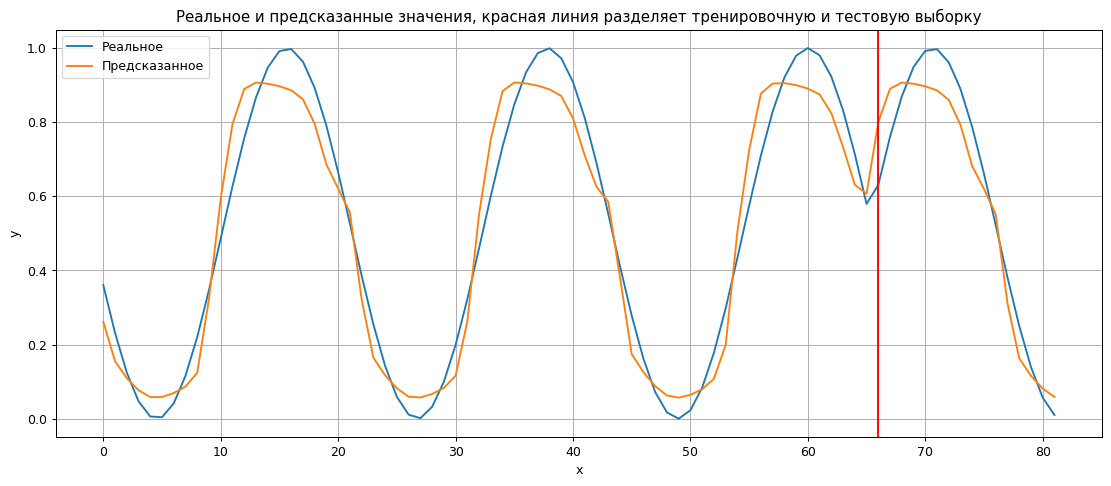

In [38]:
# Plot the result
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=90)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Реальное', 'Предсказанное'])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Реальное и предсказанные значения, красная линия разделяет тренировочную и тестовую выборку')
    plt.grid()
plot_result(trainY, testY, train_predict, test_predict)